In [26]:
import seaborn as sns
import os, sys
import numpy as np
sns.set_theme(style="white", palette="muted", font_scale=0.8)

import mpl_fontkit as fk
# 1. Install and register Inter
fk.install("Inter")  
fk.set_font("Inter")  

import matplotlib.pyplot as plt

# # — Use TrueType embedding (requires matplotlib≥3.10.1):
# plt.rcParams['pdf.fonttype'] = 3
# plt.rcParams['ps.fonttype']  = 3


# Set the default font size for all plots
plt.rcParams['font.size'] = 10

textwidth = 6.32283  # inches from 455,24411 pt textwidth in the document
# set default figure width to textwidth
plt.rcParams['figure.figsize'] = (textwidth, textwidth * 0.618)  # golden ratio
plt.rcParams['figure.dpi'] = 300  # high-quality output

color_array = sns.color_palette("muted", 10)

Font name: `Inter`


In [27]:
import numpy as np
from scipy.optimize import least_squares

def cable_path(p0, p1, cable_length, resolution=0.01):
    p0, p1 = np.array(p0, float), np.array(p1, float)
    straight_dist = np.linalg.norm(p1 - p0)
    # Too short? —> straight line
    if cable_length <= straight_dist or straight_dist < 1e-6:
        t = np.linspace(0, 1, int(np.ceil(straight_dist / resolution)) + 1)
        return np.outer(1 - t, p0) + np.outer(t, p1)

    # Horizontal span & direction
    delta = p1 - p0
    dh = np.linalg.norm(delta[:2])
    e_h = (delta[:2] / dh).tolist() + [0.0] if dh >= 1e-6 else [1.0, 0.0, 0.0]
    S = dh
    z0, z1 = p0[2], p1[2]

    # Residuals for [a, u]
    def eqs(vars):
        a, u = vars
        return [
            a * (np.cosh((S - u) / a) - np.cosh(u / a)) - (z1 - z0),
            a * (np.sinh((S - u) / a) + np.sinh(u / a)) - cable_length
        ]

    # Initial guess
    a0 = cable_length**2 / (8 * (cable_length - S)) if cable_length != S else S / 2
    guess = [a0, S / 2]

    # Solve with positivity bounds on a and 0≤u≤S
    bounds = ([1e-6, 0], [np.inf, S])
    sol = least_squares(eqs, guess, bounds=bounds)
    a, u = sol.x

    # Build catenary
    C = z0 - a * np.cosh(u / a)
    xs = np.linspace(0, S, int(np.ceil(S / resolution)) + 1)
    zs = a * np.cosh((xs - u) / a) + C

    # Map back to 3D
    eh = np.array(e_h)
    points = p0 + np.outer(xs, eh) + np.outer(zs - z0, [0, 0, 1])
    return points

In [28]:

class JSONExperiment:
    """
    Loads all JSON-formatted experiment logs from a directory,
    aggregates fields across runs, and sets them as attributes.

    Numeric list fields are converted to NumPy arrays and stacked
    into arrays of shape (timesteps, runs, ...).

    Example:
        exp = JSONExperiment('data/experiments')
        print(exp.num_runs)
        print(exp.payload_pos.shape)  # (timesteps, runs, 3)
    """
    def __init__(self, dir_path: str):
        import os, glob, json
        self._dir_path = dir_path
        # Discover JSON files
        file_paths = sorted(glob.glob(os.path.join(dir_path, '*.json')))
        self.num_runs = len(file_paths)
        print(f"Found {self.num_runs} runs in {dir_path}")
        self.run_paths = file_paths
        # Load each run's raw data
        raw_runs = []
        self.run_indices = []
        for fp in file_paths:
            with open(fp, 'r') as f:
                data = json.load(f)
            raw_runs.append(data)
            self.run_indices.append(data.get('run_index', None))

        # Determine all keys present
        all_keys = set().union(*(run.keys() for run in raw_runs))
        # Fields to convert and stack as arrays
        array_fields = ['time', 'dones', 'trajectory',
                        'payload_pos', 'payload_vel', 'payload_error',
                        'payload_linvel', 'agent_rel_pos', 'agent_rot_flat',
                        'agent_linvel', 'agent_angvel', 'agent_action',
                        'quad_pos', 'quad_vel', 'quad_rot']

        for key in all_keys:
            # Gather values per run
            vals = [run.get(key, None) for run in raw_runs]
            if key in array_fields and any(v is not None for v in vals):
                # Convert list to arrays
                arrs = []
                for v in vals:
                    try:
                        arrs.append(np.array(v))
                    except Exception:
                        arrs.append(None)
                # Stack only non-None arrays
                valid = [a for a in arrs if a is not None]
                if valid:
                    try:
                        stacked = np.stack(arrs, axis=1)
                    except Exception:
                        # Fallback: leave as list of arrays
                        stacked = arrs
                    setattr(self, key, stacked)
                else:
                    setattr(self, key, None)
            else:
                # Non-array or missing: keep list of run values
                setattr(self, key, vals)

            # Convert quad_rot quaternions to rotation matrices with shape (time, run, quad, 9)
            if 'quad_rot' in all_keys:
                # raw_runs contains one entry per run: each run['quad_rot'] has shape (timesteps, quads, 4)
                quats = np.array([run.get('quad_rot', None) for run in raw_runs])  # (runs, time, quads, 4)
            
                if quats.ndim == 4 and quats.shape[1] > 0:
                    # reorder to (time, runs, quads, 4)
                    quats = np.transpose(quats, (1, 0, 2, 3))
                    t, r, q, _ = quats.shape
                    from scipy.spatial.transform import Rotation as R
                    quats = quats.reshape(-1, 4)  # flatten to (t*r*q, 4), convert to (t*r*q, 3, 3), then reshape and flatten last two dims
                    # quats a w, x, y, z, so we need to change the order to x, y, z, w
                    quats = quats[:, [1, 2, 3, 0]]
                    rots = R.from_quat(quats).as_matrix()  # convert quatern

                    self.agent_rot_flat = rots.reshape(t, r, q, 9)
                  
            else:
                self.agent_rot_flat = None

        
        self.trajectory = None
        self.full_runs = range(self.num_runs)
        self.env_config = raw_runs[0].get('env_config', {})

        self.num_quads = self.env_config.get('num_quads', 1)



    def __repr__(self):
        return (
            f"<JSONExperiment dir={self._dir_path!r} "
            f"runs={self.num_runs} timesteps={getattr(self, 'time', None).shape[0] if hasattr(self, 'time') and isinstance(self.time, np.ndarray) else 'N/A'}>"
        )


Found 10 runs in /Users/viktorlorentz/Dev/ma/crazyflie-sim/data/output


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Plotting 10 runs: [0 1 2 3 4 5 6 7 8 9]


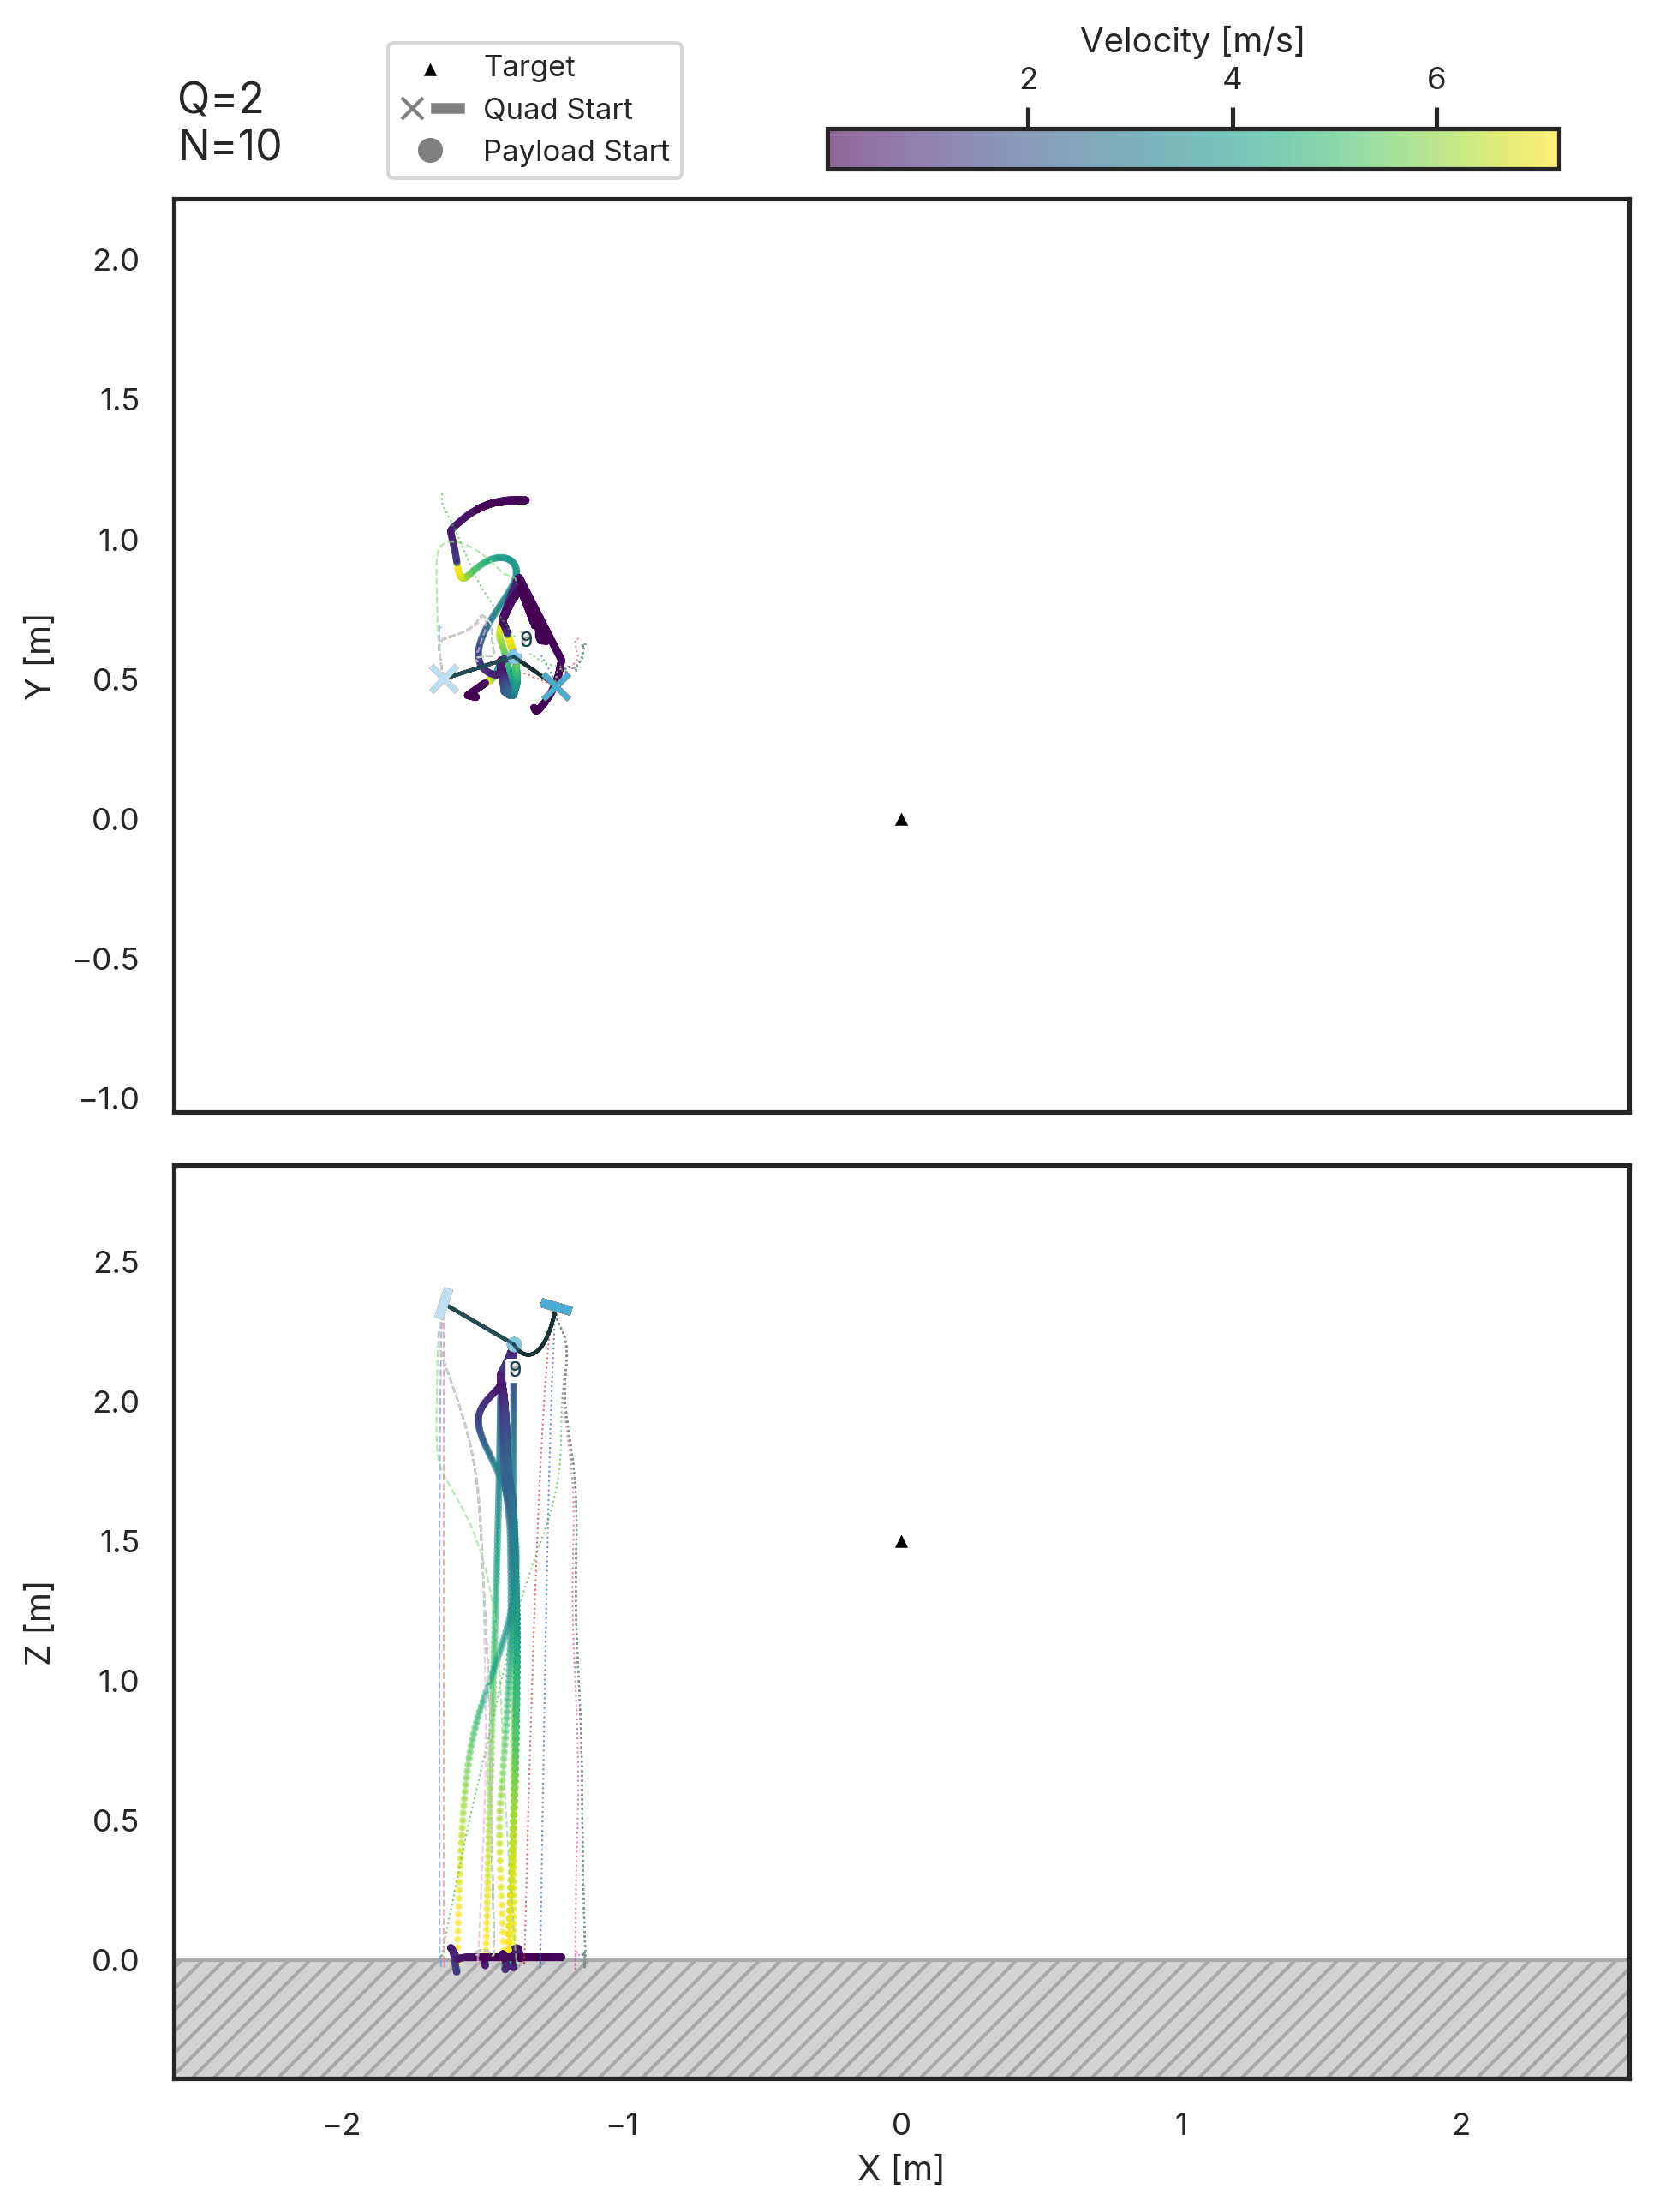

In [29]:

import colorsys
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D


def _adjust_lightness(rgb, factor):
    """Lighten (factor>1) or darken (factor<1) an RGB tuple."""
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

def plot_xy_zx_plane(exp,
                     runs=None,
                     width: float = textwidth,
                     show_quads: bool = True,
                     time: slice = None,
                     xlimits: tuple = None,
                     zlimits: tuple = None,
                     color_info: str = "time",  # 'time' or 'velocity'
                     show_run_id: bool = False,
                     reduce_quad_id: bool = True,  # reduce run ID to 0,1,2,3,...
                     show_failed: bool = False  # show runs that failed to complete
                     ):
    """
    - Top: XY plane.  Bottom: ZX plane.
    - Share X axis, slim colorbar, single legend.
    - Equal-width boxes via adjustable='datalim'.
    - Manual X/Z limits allowed; Y auto for equal aspect.
    - Rotated quad rectangles in ZX from exp.agent_rot_flat.
    - Ground rectangle for z<0 in ZX.
    - Color of payload trajectory represents time or velocity norm.
    - Annotate each payload start with its run ID (reduced or original).
    - Legend entry for Quad Start shows both 'x' marker and filled rectangle.
    - Uses exp.quad_pos (absolute quad positions) instead of computing from rel+payload.
    """
    # choose runs
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs[runs] if runs is not None else all_runs
    completed = run_idxs
    print(f"Plotting {len(run_idxs)} runs: {run_idxs}")
    if  not show_failed:
        completed = np.intersect1d(exp.full_runs, run_idxs)

    # time slice
    t_idx = time if time is not None else slice(None)
    rots_flat = exp.agent_rot_flat  # shape (T, runs, quads, 9)
    cable_length = exp.env_config['cable_length']
    quad_w, quad_h = 0.10, 0.02
    base_colors = sns.color_palette("muted", n_colors=len(completed))

    velocity = exp.payload_linvel  # shape (T, runs, 3)

    # setup figure
    fig, (ax_xy, ax_zx) = plt.subplots(
        2, 1, sharex=True,
        figsize=(width, width * 0.618 * 2),
        gridspec_kw={'hspace': 0.05},
        constrained_layout=True
    )

    all_x = []
    planes = [(ax_xy, 1), (ax_zx, 2)]

    cmap_name = 'crest' if color_info == 'time' else 'viridis'

    # background trajectory
    traj = exp.trajectory
    if traj is not None and traj.shape and traj.shape[1] == 3:
        tt = traj[t_idx, :]
        all_x.extend(tt[:, 0])
        for ax, zi in planes:
            ax.plot(tt[:, 0], tt[:, zi], color='gray', alpha=0.5, lw=1, label='Reference Trajectory')

    # per-run plotting
    for run_i, idx in enumerate(completed):
        disp_id = run_i if reduce_quad_id else idx
        base = base_colors[run_i]
        rel = exp.payload_pos[t_idx, idx, :]
        times = exp.time[t_idx]
        all_x.extend(rel[:, 0])

        # color values
        if color_info == 'time':
            cvals = times
            c_label = 'Time [s]'
        else:
            # support both 4D (T, runs, quads, 3) and 3D (T, runs, 3) velocity arrays
            if velocity.ndim == 4:
                vels = velocity[t_idx, idx, 0, :]
            else:
                vels = velocity[t_idx, idx, :]
            cvals = np.linalg.norm(vels, axis=1)
            c_label = 'Velocity [m/s]'

        # payload scatter
        for ax, zi in planes:
            sc = ax.scatter(rel[:, 0], rel[:, zi], c=cvals, cmap=cmap_name, s=1, alpha=0.6)

        # payload start
        start = rel[0]
        ax_xy.scatter(start[0], start[1], s=10, marker='o', color=base, zorder=5)
        ax_zx.scatter(start[0], start[2], s=10, marker='o', color=base, zorder=5)

        if show_run_id:
            text_color = _adjust_lightness(base, 0.3)
            ax_xy.text(start[0]+0.02, start[1]+0.02, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))
            ax_zx.text(start[0]-0.02, start[2]-0.13, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))

        # quads & cables using exp.quad_pos
        if show_quads:
            for q in range(exp.num_quads):
                quad = exp.quad_pos[t_idx, idx, q, :]  # absolute positions
                xs = quad[:, 0]
                all_x.extend(xs)

                # color & linestyle per quad
                if q == 0:
                    color = _adjust_lightness(base, 1.2); ls = '--'
                elif q == 1:
                    color = _adjust_lightness(base, 0.8); ls = ':'
                else:
                    color = base; ls = '-.'

                # quad trajectories
                for ax, zi in planes:
                    ys = quad[:, zi]
                    ax.plot(xs, ys, linestyle=ls, lw=0.5, alpha=0.7, color=color)

                # quad start marker
                ax_xy.scatter(xs[0], quad[0, 1], marker='x', s=50, color=color, zorder=6)

                # cable at start
                p_pay, p_quad = start, quad[0]
                cable_pts = cable_path(p_pay, p_quad, cable_length)
                cable_color = _adjust_lightness(color, 0.3)
                ax_xy.plot(cable_pts[:, 0], cable_pts[:, 1], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)
                ax_zx.plot(cable_pts[:, 0], cable_pts[:, 2], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)

                # rotated quad rectangle
               
                x0, z0 = p_quad[0] - quad_w/2, p_quad[2] - quad_h/2
                rect = Rectangle((x0, z0), quad_w, quad_h,
                                 edgecolor=color, facecolor=color, lw=1, zorder=6)
                if rots_flat is not None:
                    R =rots_flat[0, idx, q, :].reshape( 3,3)
                    wvec = R[:, 0] * quad_w
                    angle = np.degrees(np.arctan2(wvec[2], wvec[0]))
                    t_mat = Affine2D().rotate_deg_around(p_quad[0], p_quad[2], angle) + ax_zx.transData
                    rect.set_transform(t_mat)
                ax_zx.add_patch(rect)

    # hide top X labels
    plt.setp(ax_xy.get_xticklabels(), visible=False)

    

    # apply limits
    if xlimits is not None:
        ax_xy.set_xlim(xlimits)
    else:
        xmin, xmax = min(all_x), max(all_x)
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
        ax_xy.set_xlim(xmin - pad, xmax + pad)
    if zlimits is not None:
        ax_zx.set_ylim(zlimits)

    # ground rectangle
    x0, x1 = ax_xy.get_xlim()
    gz0, gz1 = ax_zx.get_ylim()[0], min(0, ax_zx.get_ylim()[1])
    if gz0 < 0:
        ground = Rectangle((x0, -0.5), x1 - x0, 0.5, facecolor='lightgray', edgecolor='darkgray', linewidth=1, hatch='////', zorder=-1)
        ax_zx.add_patch(ground)

    # make sure y min is at least -0.1
    y_min = ax_zx.get_ylim()[0]
    if y_min < -0.1:
        ax_zx.set_ylim(-0.1, ax_zx.get_ylim()[1])

   

    # target position
    if traj is None or not traj.shape or traj.shape[1] != 3:
        target = np.array([0.0, 0.0, 1.5])
        ax_xy.scatter(target[0], target[1], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)
        ax_zx.scatter(target[0], target[2], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)

    fig.text(0.1, 1.01, f'Q={exp.num_quads}\nN={len(completed)}', fontsize=12, ha='left', va='bottom')

    # equal aspect & align
    for ax in (ax_xy, ax_zx):
        ax.set_aspect('equal', adjustable='datalim')
    fig.align_ylabels((ax_xy, ax_zx))

    # axis labels
    ax_xy.set_ylabel('Y [m]')
    ax_zx.set_ylabel('Z [m]')
    ax_zx.set_xlabel('X [m]')

    # colorbar
    cbar_ax = fig.add_axes([0.5, 1.01, 0.45, 0.02])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', fraction=0.01, pad=0.01)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.tick_top()
    cbar.set_label(c_label)

    # legend assembly
    handles, labels = [], []
    for ax in (ax_xy, ax_zx):
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li and li not in labels:
                handles.append(hi)
                labels.append(li)
        if ax.legend_:
            ax.legend_.remove()

    # custom combined handle: quad start as cross + thick line
    quad_marker = Line2D([], [], marker='x', linestyle='None', color='gray')
    legend_line = Line2D([], [], linestyle='-', linewidth=3, color='gray', solid_capstyle='projecting')
    payload_marker = Line2D([], [], marker='o', linestyle='None', color='gray')
    handles.append((quad_marker, legend_line))
    labels.append('Quad Start')
    handles.append(payload_marker)
    labels.append('Payload Start')

    fig.legend(handles, labels,
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='upper center', ncol=1, fontsize='small', bbox_to_anchor=(0.32, 1.08))

    return fig


baseline_recovery = JSONExperiment('/Users/viktorlorentz/Dev/ma/crazyflie-sim/data/output')

#slice(320,342) 
#slice(329,352) [376, 387, 302, 382, 394, 352,390,34][376, 387, 302, 382,259, 58, 290, 562]
baseline_rec = plot_xy_zx_plane(baseline_recovery, show_quads=True, xlimits=(-2.6, 2.6),  color_info='velocity', show_run_id=True, reduce_quad_id=False, show_failed=True);


# #save figures
#baseline_rec.savefig('out/baseline_recovery.pdf', bbox_inches='tight')


Experiment loaded from ../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf with 2 quads


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


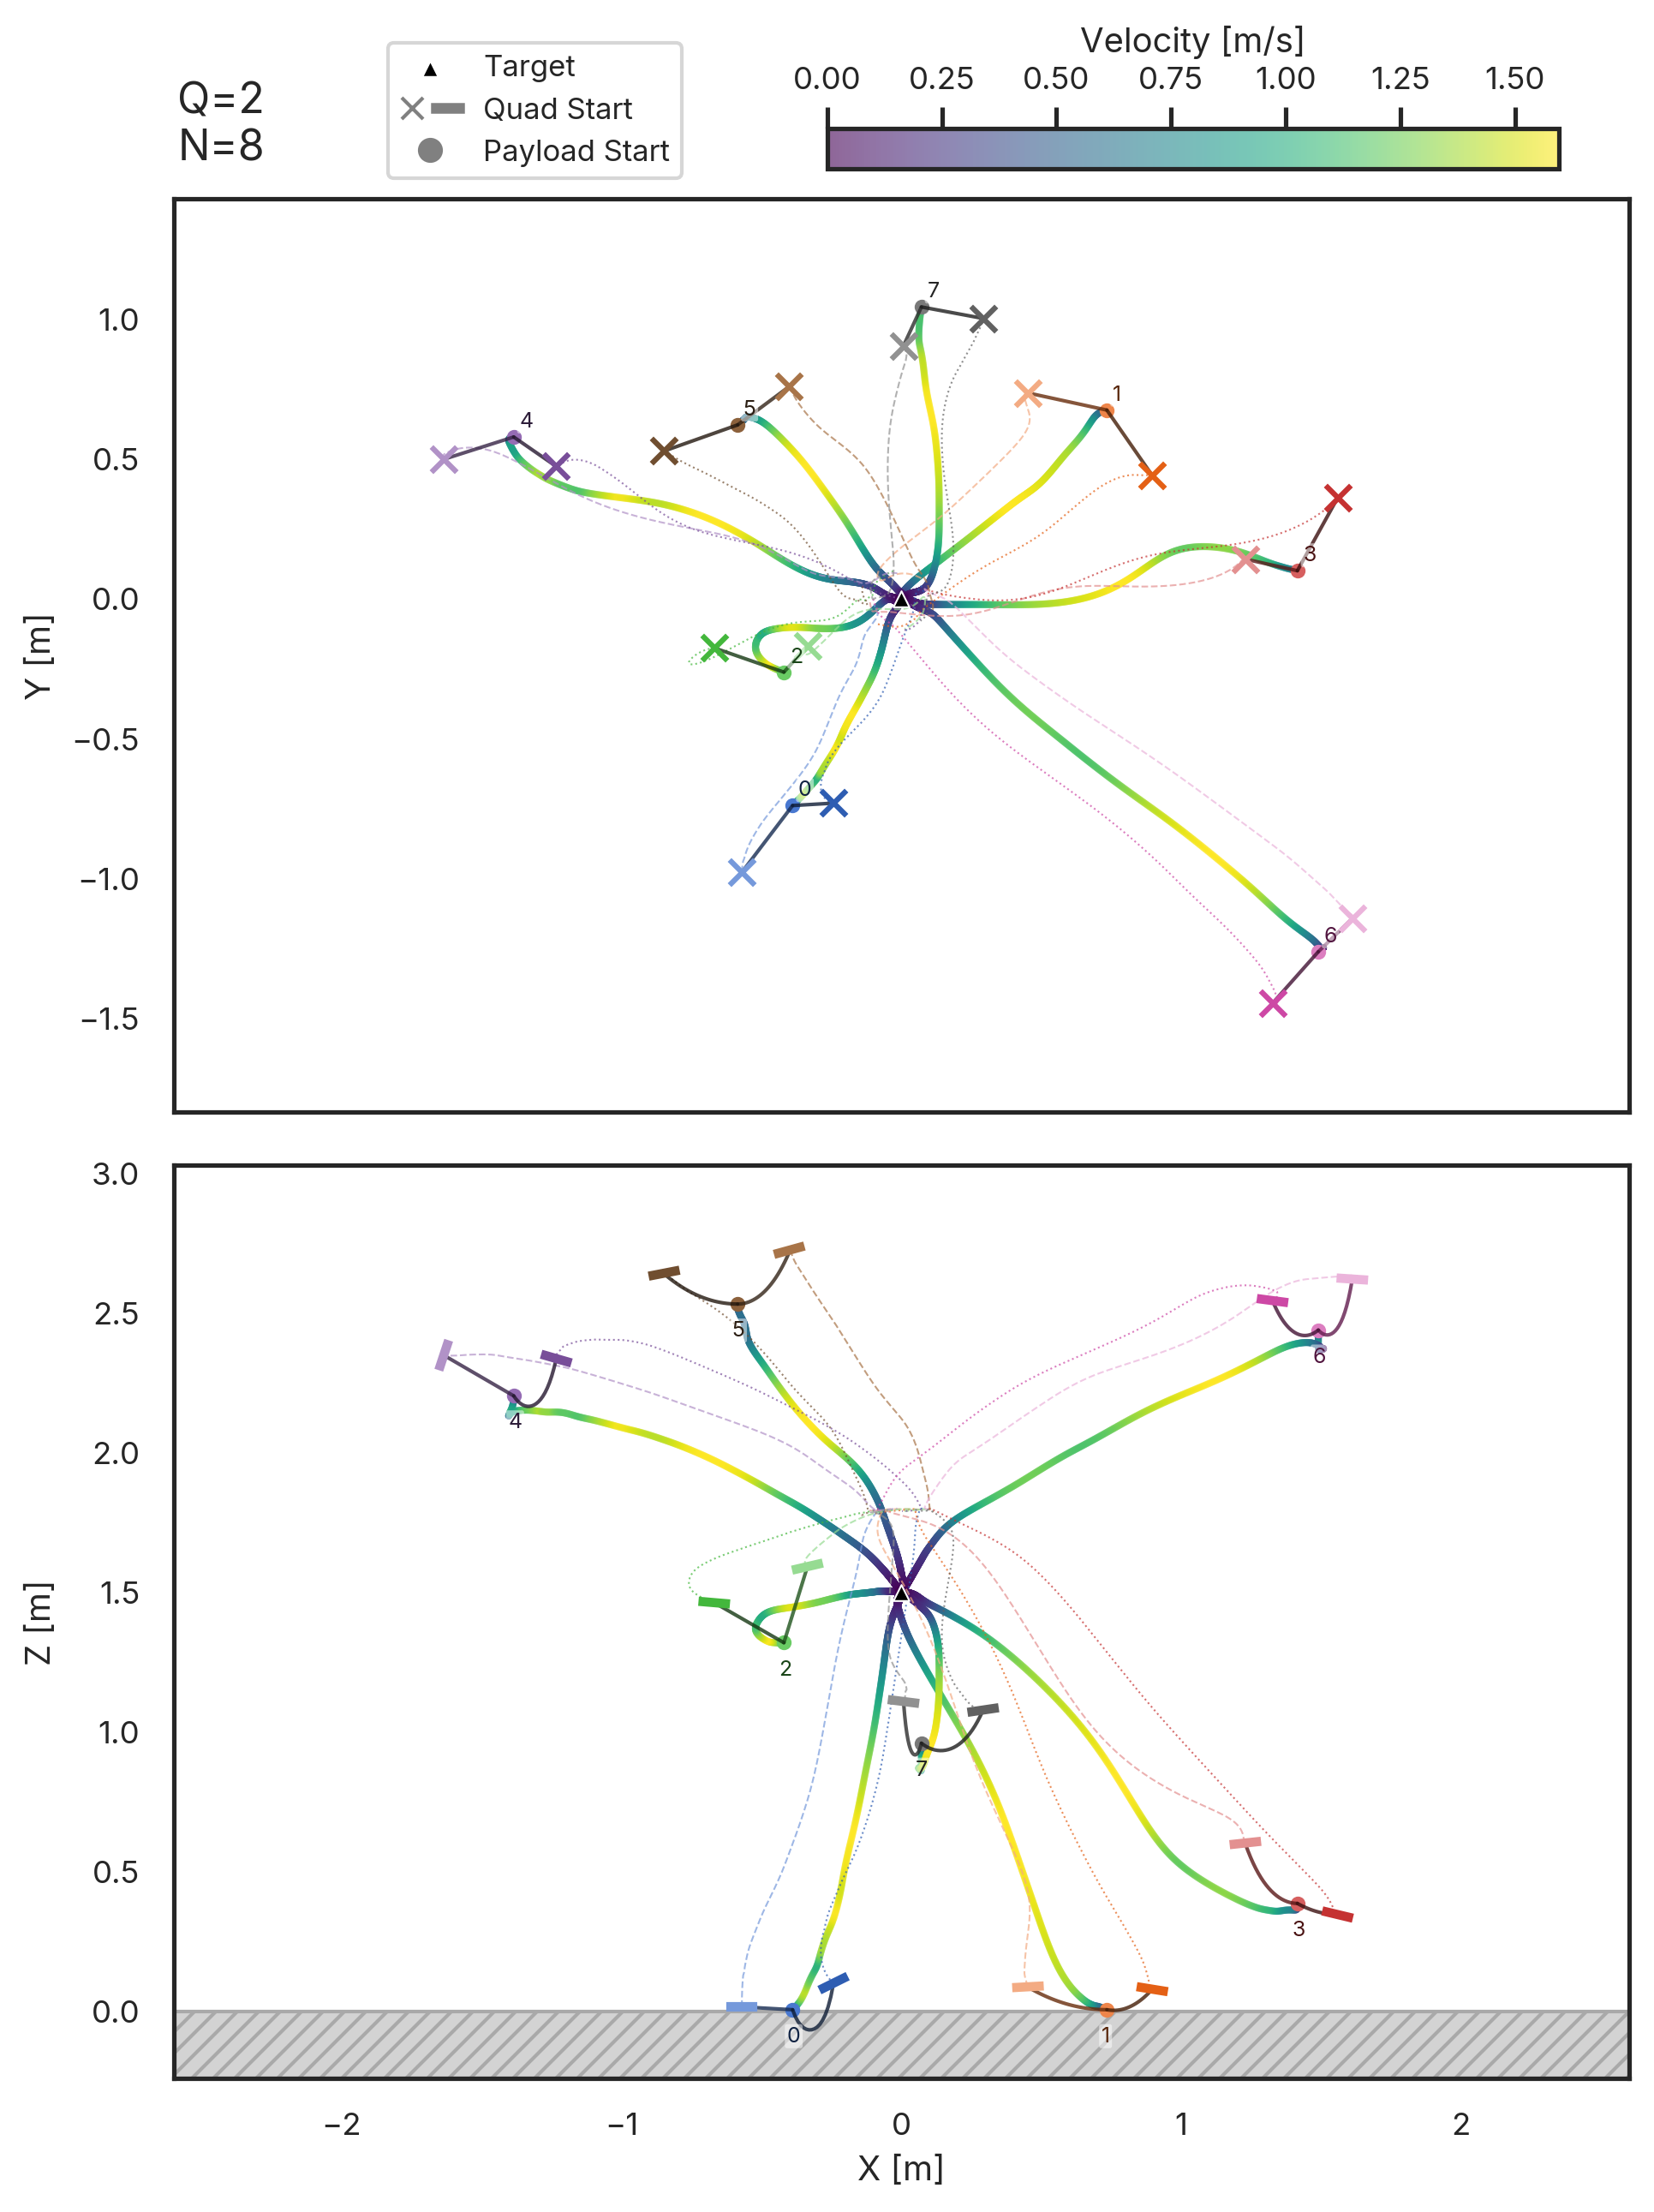

In [30]:

import colorsys
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
import jax
jax.config.update("jax_platform_name", "cpu")


import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
from crazymarl.experiments.experiment_loader import Experiment


def _adjust_lightness(rgb, factor):
    """Lighten (factor>1) or darken (factor<1) an RGB tuple."""
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

def plot_xy_zx_plane(exp: Experiment,
                     runs=None,
                     width: float = textwidth,
                     show_quads: bool = True,
                     time: slice = None,
                     xlimits: tuple = None,
                     zlimits: tuple = None,
                     color_info: str = "time",  # 'time' or 'velocity'
                     show_run_id: bool = False,
                     reduce_quad_id: bool = True,  # reduce run ID to 0,1,2,3,...
                     show_failed: bool = False  # show runs that failed to complete
                     ):
    """
    - Top: XY plane.  Bottom: ZX plane.
    - Share X axis, slim colorbar, single legend.
    - Equal-width boxes via adjustable='datalim'.
    - Manual X/Z limits allowed; Y auto for equal aspect.
    - Rotated quad rectangles in ZX from exp.agent_rot_flat.
    - Ground rectangle for z<0 in ZX.
    - Color of payload trajectory represents time or velocity norm.
    - Annotate each payload start with its run ID (reduced or original).
    - Legend entry for Quad Start shows both 'x' marker and filled rectangle.
    - Uses exp.quad_pos (absolute quad positions) instead of computing from rel+payload.
    """
    # choose runs
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs[runs] if runs is not None else np.array([0])
    completed = run_idxs
    if  not show_failed:
        completed = np.intersect1d(exp.full_runs, run_idxs)

    # time slice
    t_idx = time if time is not None else slice(None)
    rots_flat = exp.agent_rot_flat  # shape (T, runs, quads, 9)
    cable_length = exp.env_config['cable_length']
    quad_w, quad_h = 0.10, 0.02
    base_colors = sns.color_palette("muted", n_colors=len(completed))

    velocity = exp.payload_linvel  # shape (T, runs, 3)

    # setup figure
    fig, (ax_xy, ax_zx) = plt.subplots(
        2, 1, sharex=True,
        figsize=(width, width * 0.618 * 2),
        gridspec_kw={'hspace': 0.05},
        constrained_layout=True
    )

    all_x = []
    planes = [(ax_xy, 1), (ax_zx, 2)]

    cmap_name = 'crest' if color_info == 'time' else 'viridis'

    # background trajectory
    traj = exp.trajectory
    if traj is not None and traj.shape and traj.shape[1] == 3:
        tt = traj[t_idx, :]
        all_x.extend(tt[:, 0])
        for ax, zi in planes:
            ax.plot(tt[:, 0], tt[:, zi], color='gray', alpha=0.5, lw=1, label='Reference Trajectory')

    # per-run plotting
    for run_i, idx in enumerate(completed):
        disp_id = run_i if reduce_quad_id else idx
        base = base_colors[run_i]
        rel = exp.payload_pos[t_idx, idx, :]
        times = exp.time[t_idx]
        all_x.extend(rel[:, 0])

        # color values
        if color_info == 'time':
            cvals = times
            c_label = 'Time [s]'
        else:
            vels = velocity[t_idx, idx, 0, :]
            cvals = np.linalg.norm(vels, axis=1)
            c_label = 'Velocity [m/s]'

        # payload scatter
        for ax, zi in planes:
            sc = ax.scatter(rel[:, 0], rel[:, zi], c=cvals, cmap=cmap_name, s=1, alpha=0.6)

        # payload start
        start = rel[0]
        ax_xy.scatter(start[0], start[1], s=10, marker='o', color=base, zorder=5)
        ax_zx.scatter(start[0], start[2], s=10, marker='o', color=base, zorder=5)

        if show_run_id:
            text_color = _adjust_lightness(base, 0.3)
            ax_xy.text(start[0]+0.02, start[1]+0.02, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))
            ax_zx.text(start[0]-0.02, start[2]-0.13, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))

        # quads & cables using exp.quad_pos
        if show_quads:
            for q in range(exp.num_quads):
                quad = exp.quad_pos[t_idx, idx, q, :]  # absolute positions
                xs = quad[:, 0]
                all_x.extend(xs)

                # color & linestyle per quad
                if q == 0:
                    color = _adjust_lightness(base, 1.2); ls = '--'
                elif q == 1:
                    color = _adjust_lightness(base, 0.8); ls = ':'
                else:
                    color = base; ls = '-.'

                # quad trajectories
                for ax, zi in planes:
                    ys = quad[:, zi]
                    ax.plot(xs, ys, linestyle=ls, lw=0.5, alpha=0.7, color=color)

                # quad start marker
                ax_xy.scatter(xs[0], quad[0, 1], marker='x', s=50, color=color, zorder=6)

                # cable at start
                p_pay, p_quad = start, quad[0]
                cable_pts = cable_path(p_pay, p_quad, cable_length)
                cable_color = _adjust_lightness(color, 0.3)
                ax_xy.plot(cable_pts[:, 0], cable_pts[:, 1], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)
                ax_zx.plot(cable_pts[:, 0], cable_pts[:, 2], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)

                # rotated quad rectangle
                R =rots_flat[0, idx, q, :].reshape(3,3)
           
                wvec = R[:, 0] * quad_w
                angle = np.degrees(np.arctan2(wvec[2], wvec[0]))
                x0, z0 = p_quad[0] - quad_w/2, p_quad[2] - quad_h/2
                rect = Rectangle((x0, z0), quad_w, quad_h,
                                 edgecolor=color, facecolor=color, lw=1, zorder=6)
                t_mat = Affine2D().rotate_deg_around(p_quad[0], p_quad[2], angle) + ax_zx.transData
                rect.set_transform(t_mat)
                ax_zx.add_patch(rect)

    # hide top X labels
    plt.setp(ax_xy.get_xticklabels(), visible=False)

    

    # apply limits
    if xlimits is not None:
        ax_xy.set_xlim(xlimits)
    else:
        xmin, xmax = min(all_x), max(all_x)
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
        ax_xy.set_xlim(xmin - pad, xmax + pad)
    if zlimits is not None:
        ax_zx.set_ylim(zlimits)

    # ground rectangle
    x0, x1 = ax_xy.get_xlim()
    gz0, gz1 = ax_zx.get_ylim()[0], min(0, ax_zx.get_ylim()[1])
    if gz0 < 0:
        ground = Rectangle((x0, -0.5), x1 - x0, 0.5, facecolor='lightgray', edgecolor='darkgray', linewidth=1, hatch='////', zorder=-1)
        ax_zx.add_patch(ground)

    # make sure y min is at least -0.1
    y_min = ax_zx.get_ylim()[0]
    if y_min < -0.1:
        ax_zx.set_ylim(-0.1, ax_zx.get_ylim()[1])

   

    # target position
    if traj is None or not traj.shape or traj.shape[1] != 3:
        target = np.array([0.0, 0.0, 1.5])
        ax_xy.scatter(target[0], target[1], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)
        ax_zx.scatter(target[0], target[2], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)

    fig.text(0.1, 1.01, f'Q={exp.num_quads}\nN={len(completed)}', fontsize=12, ha='left', va='bottom')

    # equal aspect & align
    for ax in (ax_xy, ax_zx):
        ax.set_aspect('equal', adjustable='datalim')
    fig.align_ylabels((ax_xy, ax_zx))

    # axis labels
    ax_xy.set_ylabel('Y [m]')
    ax_zx.set_ylabel('Z [m]')
    ax_zx.set_xlabel('X [m]')

    # colorbar
    cbar_ax = fig.add_axes([0.5, 1.01, 0.45, 0.02])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', fraction=0.01, pad=0.01)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.tick_top()
    cbar.set_label(c_label)

    # legend assembly
    handles, labels = [], []
    for ax in (ax_xy, ax_zx):
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li and li not in labels:
                handles.append(hi)
                labels.append(li)
        if ax.legend_:
            ax.legend_.remove()

    # custom combined handle: quad start as cross + thick line
    quad_marker = Line2D([], [], marker='x', linestyle='None', color='gray')
    legend_line = Line2D([], [], linestyle='-', linewidth=3, color='gray', solid_capstyle='projecting')
    payload_marker = Line2D([], [], marker='o', linestyle='None', color='gray')
    handles.append((quad_marker, legend_line))
    labels.append('Quad Start')
    handles.append(payload_marker)
    labels.append('Payload Start')

    fig.legend(handles, labels,
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='upper center', ncol=1, fontsize='small', bbox_to_anchor=(0.32, 1.08))

    return fig


two_recovery = Experiment('../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf')


two_rec = plot_xy_zx_plane(two_recovery, runs=[376, 387, 302, 382,259, 58, 290, 562], show_quads=True, xlimits=(-2.6, 2.6),  color_info='velocity', show_run_id=True);


